In [1]:
%run Latex_macros.ipynb

<IPython.core.display.Latex object>

In [2]:
# My standard magic !  You will see this in almost all my notebooks.

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

%matplotlib inline

In [3]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Common imports
import os

import svm_helper
%aimport svm_helper
svmh = svm_helper.SVM_Helper()

%matplotlib inline


# Kernel functions

The classifiers that we have studied are Linear: they create boudaries that are linear in the features in an attempt to separate classes.

That is: they work well when the classes are (nearly) Linearly Separable.



What if our classes don't appear to be Linearly Separable ?

We can try transforming the features so that, in the transformed features, the classes are separable.

# Transformations to induce Linear Separability

Transformations to induce linearity are interesting because
- they make our data linear in the new dimensions (features)
- when mapped back to our original dimensions, they introduce non-linearity, which can be powerful

As we will see, non-linear decision boundaries are a key part of Deep Learning.

In Classical Machine Learning, these transformations serve a similar role.

Let's explore a classification problem.  
- The colors denote different classes.
- We won't name the $\x_1, \x_2$ features

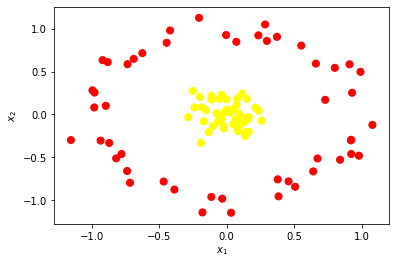

In [4]:
Xc, yc = svmh.make_circles(plot=True)

Doesn't appear to be linearly separable.

But, as we saw in the Transformation lecture, an RBF transformation does the trick:

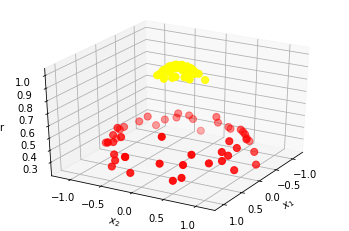

In [5]:
X_w_rbf = svmh.circles_rbf_transform(Xc)
_= svmh.plot_3D(X=X_w_rbf, y=yc )

Magic ! The new feature separates the two classes.
- just like the polynomial feature make the curvy data set linear

The particular transformation is called Radial Basis Function (RBF) Transformation.

Here's the code that created the new feature "r".

Simple.  

Basically, the transformation creates a scalar measure (*similarity function*) of the distance between
the existing features $\x^\ip$ of example $i$ and the features of a reference point.

In this case the reference point ("landmark") is the origin $(0,0)$ so
we don't write it explicitly.

In general the distance would be coded as
 `Xc - x_ref`
 
Examples that are very
close to the reference point have high values, and the values fall off sharply as the distance increases.


# Support Vector Machines: SVC's with integrated transformations

Nothing we have said above Linearity Inducing transformations should be new to you.

It is just like any other problem:
- apply transformations
- apply a model (Classifier)

A *Support Vector Machine* is an SVC that has been integrated with a *special class of transformations*.

These transformations are intimately tied to the mathematics of the SVC.

So rather than applying transformations as a pre-processing step (as above), the SVM integrates
these special transformations into its basic algorithm.

These special class of transformations are known as *kernels*.

## Kernels and the Kernel Trick

*Kernels* are a powerful form of transformation because they can be computed especially efficiently
when used in conjunction with an SVC.

Consider a transformation $\Phi$ applied to a feature vector $\x^\ip$ of length $n$: $\phi(\x^\ip)$

Quite often, $\phi(\x^\ip)$ creates a vector $\tx^\ip$ of length $n' \gg n$.

For example, the "circle within a circle" example used a transformation that added one new feature.

Adding features may be costly (in fact, the RBF can add an infinite number of features !)

A *kernel transformation* allows the SVC to achieve the *effect* of having performed the transformation
**without actually performing it**!

It is able to do this by relating the transformation to the mathematics of algorithms that solve the SVC
optimization problem (minimization of Loss function).

We present, without proof, some properties of efficient solvers for
the SVM problem.

The SVC optimization problem can be formulated as a 
Quadratic Programming problem.

A Quadratic Programming problems can be reformulated into a twin problem called 
its *dual form*.  The dual form for the SVC optimization problem is

**Dual form of the linear SVM objective (similar to Geron Equation 5-6)**

$
\begin{split}
\underset{\mathbf{\alpha}}{\operatorname{minimize}}
\dfrac{1}{2}\sum\limits_{i=1}^{m}{
  \sum\limits_{i'=1}^{m}{
  \alpha^{(i)} \alpha^{(i')} \transy^{(i)} \transy^{(j)} {\x^\ip}^T \x^{(i')}
  }
} \quad - \quad \sum\limits_{i=1}^{m}{\alpha^{(i)}}\\
\text{subject to}\quad \alpha^{(i)} \ge 0 \quad \text{for }i = 1, 2, \dots, m
\end{split}
$

It is beyond the scope of this course to explain the equation.

The key observations to take away from the above equation is
- the only sub-expression involving an example is when examples occur in pairs : $\x^\ip, \x^{(i')}$
- the only computation on the pair is the dot product $\x^\ip \cdot  \x^{(i')} = {\x^\ip}^T \x^{(i')}$


Thus, if we transform $\x^\ip$ to $\tx^\ip = \Phi(\x^\ip)$
our optimization problem will have sub-expressions of the form 
$$
\phi(\x^\ip) \cdot  \phi(\x^{(i')})
$$

A *kernel function* $K$ is a **shortcut** for computing the *value* of this product **without** having
to perform transformation $\phi$.

$$
K(\x^\ip, \x^{(i')}) = \phi(\x^\ip) \cdot \phi(\x^{(i')})
$$

This is particularly valuable
- if $\phi$ is expensive to compute
- if $\phi$ adds many features (i.e., $n' \gg n$)
    - because the value of the dot product is a *scalar*, it is independent of $n'$
    
**Aside**

In order for a function to be a Kernel Function, it must satisfy Mercer's Theorem.

Not all transformations have corresponding kernel functions.

Rather
- there are a number of kernel functions
- each kernel function corresponds to a transform


For this reason, although it seems backwards
- we will define a kernel function $K$
- and derive the $\phi$ implied by $K$

As we will see, there are many kernel functions whose derived $\phi$'s are similar to natural transformations.

To make this concrete: 
- consider the function $K$ that 
compares two examples with
a second order polynomial transformation
$$
K(\x^\ip, \x^{(i')}) = (\x^\ip \cdot \x^{(i')})^2
$$

The $\phi$ corresponding to $K$ (illustrated for $\x$ with $2$ features) is

$
\phi\left(\mathbf{x}\right) = \phi\left( \begin{pmatrix}
  x_1 \\
  x_2
\end{pmatrix} \right) = \begin{pmatrix}
  {x_1}^2 \\
  \sqrt{2} \, x_1 x_2 \\
  {x_2}^2
\end{pmatrix}
$

Notice that the Polynomial kernel above is not the same as the "natural" transformation that
simply squares each feature.
- it adds a third "cross" term

We can prove that $K$ is a kernel function by computing the dot product of $\phi(\x^\ip) \cdot \phi(\x^{(i')})$ and showing it to be equal to $K((\x^\ip, \x^{(i')})$


$$
\begin{array}[llll]\\
\phi(\mathbf{\x^\ip})^T \phi(\x^{(i')})  & = & 
\begin{pmatrix}
  {\x^\ip_1}^2 \\
  \sqrt{2} \, \x^\ip_1 \x^\ip_2 \\
  {\x^\ip_2}^2
  \end{pmatrix}^T \begin{pmatrix}
  {\x^{(i')}_1}^2 \\
  \sqrt{2} \, \x^{(i')}_1 \x^{(i')}_2 \\
  {\x^{(i')}_2}^2
\end{pmatrix} \\
& = & {\x^\ip_1}^2 {\x^{(i')}_1}^2 + 2 \x^\ip_1 \x^{(i')}_1 \x^\ip_2 \x^{(i')}_2 + {\x^\ip_2}^2 {\x^{(i')}_2}^2 \\
&  = & \left( \x^\ip_1 \x^{(i')}_1 + \x^\ip_2 \x^{(i')}_2 \right)^2 \\
&  = & \left( \begin{pmatrix}
  \x^\ip_1 \\
  \x^\ip_2
\end{pmatrix}^T \begin{pmatrix}
    \x^{(i')}_1 \\
    \x^{(i')}_2
  \end{pmatrix} \right)^2 \\
& = & ({\x^\ip}^T \x^{(i')})^2
\end{array}  
$$

You might try to simulate kernel functions with their natural counterparts
- transform the data with the "natural transformation", e.g., square each feature
- apply a linear SVC to the transformed data

As with the polynomial kernel above, the results won't be exactly the same.

For example, consider $\x = [ \x_1, \x_2 ]$
- The Polynomial kernel (with degree 2) transforms  $\x$ to
$$
[ \x_1^2, \x_2^2, \sqrt{2} \x_1 \x_2 ]
$$
- The Polynomial transform (with degree 2) in `sklearn` transforms $\x$ to
$$
[ 1, \x_1, \x_2, \x_1^2, \x_2^2, \x_1 \x_2 ]
$$

Here are some examples of kernel transformation, paired with their "natural" counterparts.

Why the differences ?
- the kernel transformation is not identical to the natural (e.g., Polynomial)
- possible differences in parameters

In [9]:
svmh = svm_helper.SVM_Helper()

_= svmh.create_kernel_data()
fig, axs = svmh.plot_kernel_vs_transform()
plt.close()

/home/kjp/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/kjp/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


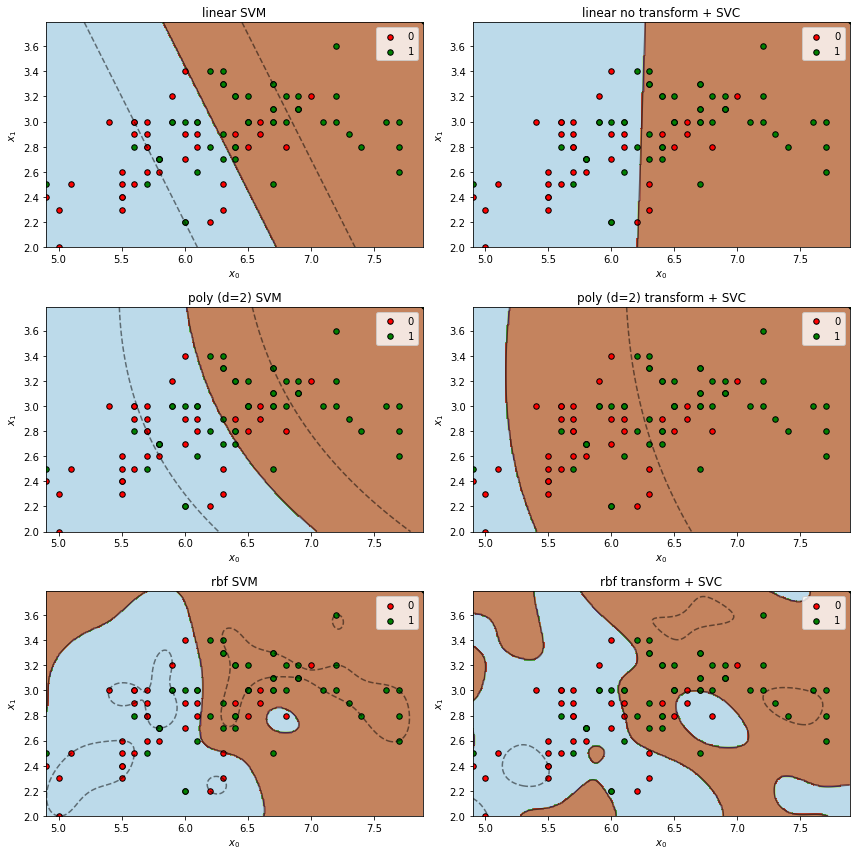

In [10]:
fig

## Some Kernel functions
[kernels](http://crsouza.com/2010/03/17/kernel-functions-for-machine-learning-applications/#linear)

There are a number of common kernel functions.
We investigate just a handful:

### Linear

The linear kernel

$$
K(\x, \x^{(i')}) = \x^T \cdot \x^{(i')} + c
$$

corresponds to a $\phi$ that is the identity transformation $\phi(\x) = \x$.

The linear kernel results in something very close to plain logistic regression.

### Gaussian

The Gaussian Radial Basis Function (RBF)

$$
K(\x, \x^{(i')}) =  \exp( - \frac{1}{2 \sigma^2} * \mid\mid  \x - \x^{(i')} \mid\mid^2 )
$$


The form of this function is that of a Gaussian distribution with mean $0$ and standard deviation $\sigma$.

The similarity is maximized when $\x$ and  $\x^{(i')}$ are close
in Euclidean space (due to the 2-norm $\mid\mid \; \mid\mid^2$)

When $\sigma$ is small, there is a sharp drop-off from the maximium at $\x^{(i')}$ to near-by points.

Conversely, when $\sigma$ is large, the drop-off is much smoother.


Note the presence of the *hyper parameter* $\sigma$.

How do we choose the right value ?

We don't need to !
- Consider $\sigma$ to be just like $\Theta$: a parameter that the optimizer solves for
    - Let the optimizer simulataneously find the best combination of $\Theta$ and $\sigma$

In [8]:
print("Done")

Done
